<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/20_8_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import libraries
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data, partition):

  train = data[:-partition]
  test = data[-partition:]
  train_original = train
  test_original = test

  # apply padding (if required) in order to split train and test array in equal windows
  if len(train) % partition != 0:
    pad_width = partition - (len(train) % partition)
    train = np.pad(train, (0,pad_width), 'constant', constant_values=(array(train).mean()))

  if len(test) % partition != 0:
    pad_width = partition - (len(test) % partition)
    test = np.pad(test, (0,pad_width), 'constant', constant_values=(array(test).mean()))
    
  # restructure into equal windows
  train = array(split(train, int(len(train)/partition)))
  test = array(split(test, int(len(test)/partition)))
  return train, test, train_original, test_original


  return train, test, train_original, test_original

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [4]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [5]:
# train the model
def build_model(train, n_input, n_out):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_out)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model


In [6]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [7]:
# evaluate a single model
def evaluate_model(train, test, n_input, n_out):
	# fit model
	model = build_model(train, n_input, n_out)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(yhat_sequence)
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions

In [8]:
#Load dataset
df1 = read_csv('/content/data_8_variables.csv')

EDA

In [9]:
df1.head(5)

,Date,Revenue,Unemployment,PPI,SoftwareSales,PCE,GDP,Covid,Cloud-OnPrem
0,1/1/2017,11141.566,4.7,91.6,16993,13015.1,6481.00,0,0.267699
1,2/1/2017,11483.520,4.6,95.4,15656,13034.7,6481.00,0,0.356420
2,3/1/2017,89026.192,4.4,97.8,21011,13089.6,6481.00,0,0.216901
3,4/1/2017,7486.732,4.5,94.1,18405,13127.7,6572.67,0,0.535412
4,5/1/2017,17719.978,4.4,95.1,19293,13128.7,6572.67,0,0.496066


In [10]:
df1.tail(10)

,Date,Revenue,Unemployment,PPI,SoftwareSales,PCE,GDP,Covid,Cloud-OnPrem
44,9/1/2020,147118.567,7.8,99.5,25029,14481.7,7079.67,1,0.470217
45,10/1/2020,43706.168,6.9,98.8,24942,14546.0,7270.33,1,0.350292
46,11/1/2020,54935.815,6.7,97.0,23015,14467.3,7270.33,1,0.238163
47,12/1/2020,519428.806,6.7,97.6,28530,14389.5,7270.33,1,0.291056
48,1/1/2021,16501.026,6.3,97.1,21862,14857.9,7812.33,1,1.166448
49,2/1/2021,55269.823,6.2,97.3,20129,14699.6,7812.33,1,0.731457
50,3/1/2021,132237.610,6.0,96.7,26123,15458.9,7812.33,1,0.459600
51,4/1/2021,20767.113,6.1,101.0,24150,15630.0,7408.33,1,0.984101
52,5/1/2021,45859.339,5.8,95.8,23228,15616.2,7408.33,1,0.826293
53,6/1/2021,183014.713,5.9,96.1,28438,15771.6,7408.33,1,0.754712


In [11]:
df1.shape

(54, 9)

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           54 non-null     object 
 1   Revenue        54 non-null     float64
 2   Unemployment   54 non-null     float64
 3   PPI            54 non-null     float64
 4   SoftwareSales  54 non-null     int64  
 5   PCE            54 non-null     float64
 6   GDP            54 non-null     float64
 7   Covid          54 non-null     int64  
 8   Cloud-OnPrem   54 non-null     float64
dtypes: float64(6), int64(2), object(1)
memory usage: 3.9+ KB


In [13]:
df1.describe()

,Revenue,Unemployment,PPI,SoftwareSales,PCE,GDP,Covid,Cloud-OnPrem
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,96305.739648,5.124074,95.268519,22152.388889,14066.309259,6981.297222,0.277778,0.491953
std,135458.084897,2.419101,3.022671,2618.448154,739.931952,328.598644,0.452109,0.250673
min,7486.732000,3.500000,88.500000,15656.000000,12021.800000,6481.000000,0.000000,0.163757
25%,19950.849000,3.800000,93.150000,20832.750000,13606.375000,6779.000000,0.000000,0.303408
50%,38736.537000,4.100000,95.150000,22532.000000,14111.150000,6952.335000,0.000000,0.433221
75%,119584.180750,5.875000,97.275000,23955.250000,14524.150000,7213.670000,1.000000,0.623677
max,724700.889000,14.800000,101.600000,28530.000000,15771.600000,7812.330000,1.000000,1.166448


In [14]:
#exclude 'Date' Column 
df = df1.drop('Date' , axis=1)

In [15]:
df1.shape

(54, 9)

Train-Test split

In [16]:
# Jan 2021 to Jun 2021 is test set
# While remaining is training set
partition = 6
train, test, train_original, test_original = split_dataset(df.values, partition)

In [17]:
train.shape, test.shape

((8, 6, 8), (1, 6, 8))

In [18]:
train_original.shape, test_original.shape

((48, 8), (6, 8))

Model Building and Evaluation

In [19]:
n_input = 12
n_out = 6

In [20]:
score, scores, pred =evaluate_model(train, test, n_input, n_out)

Convet predictions, train, test to lists for graph plotting purpose

In [21]:
predictions = pred.reshape(-1).tolist()
predictions

[35716.76953125,
 54786.41015625,
 78485.96875,
 117898.2734375,
 162791.09375,
 174043.15625]

In [22]:
test_values_list = test_original[:,0].reshape(-1).tolist()
test_values_list

[16501.026,
 55269.823,
 132237.61,
 20767.113,
 45859.33900000001,
 183014.71300000002]

In [23]:
train_values_list = train_original[:,0].reshape(-1).tolist()
train_values_list

[11141.566,
 11483.52,
 89026.192,
 7486.732,
 17719.978,
 159129.659,
 16736.302,
 25432.066000000003,
 145620.785,
 24954.743,
 42440.280999999995,
 389795.30100000004,
 10851.367,
 15156.59,
 92459.405,
 18964.488999999998,
 27080.474,
 156189.554,
 22733.732000000004,
 19094.521,
 119631.54800000001,
 21636.455,
 64590.779,
 303152.06,
 12594.348,
 24780.076,
 116184.04699999999,
 33054.437000000005,
 48772.3,
 285241.25800000003,
 27898.502999999997,
 51342.508,
 244466.379,
 34864.443,
 73088.785,
 724700.8890000001,
 16301.221000000001,
 19678.761000000002,
 119442.079,
 18721.319,
 30280.716,
 226958.057,
 25759.943,
 35032.793,
 147118.56699999998,
 43706.168,
 54935.815,
 519428.80600000004]

In [24]:
#Evaluate Model using r2_score and RMSE
MSE = mean_squared_error(test_values_list, predictions)
RMSE = int(sqrt(MSE))
R2 = r2_score(test_values_list,predictions)
print('RMSE : ' + str(RMSE))
print('R square : ' + str(R2))

RMSE : 66391
R square : -0.17317240620585572


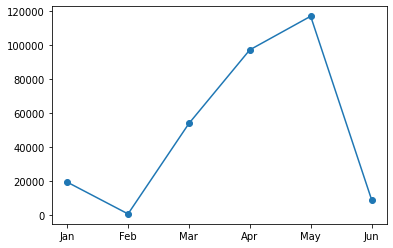

In [25]:
# plot scores
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
plt.plot(months, scores, marker='o', label='lstm')
plt.show()

Add Graph

In [26]:
#set x axis labels
vis = dict()

x_axis_label = []

for cur_date in df1['Date']:
  
  cur_year = cur_date[-4:] 
  if str(cur_year) not in vis.keys():
    vis[str(cur_year)] = 1
    x_axis_label.append(str(cur_year))
  
  else:
    x_axis_label.append('')

In [27]:
x_axis_label

['2017',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2018',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2019',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2020',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2021',
 '',
 '',
 '',
 '',
 '']

specify dates

In [28]:
dates_train = []
for i in range(len(df1)-partition):
  dates_train.append(df1['Date'][i])

dates_train

['1/1/2017',
 '2/1/2017',
 '3/1/2017',
 '4/1/2017',
 '5/1/2017',
 '6/1/2017',
 '7/1/2017',
 '8/1/2017',
 '9/1/2017',
 '10/1/2017',
 '11/1/2017',
 '12/1/2017',
 '1/1/2018',
 '2/1/2018',
 '3/1/2018',
 '4/1/2018',
 '5/1/2018',
 '6/1/2018',
 '7/1/2018',
 '8/1/2018',
 '9/1/2018',
 '10/1/2018',
 '11/1/2018',
 '12/1/2018',
 '1/1/2019',
 '2/1/2019',
 '3/1/2019',
 '4/1/2019',
 '5/1/2019',
 '6/1/2019',
 '7/1/2019',
 '8/1/2019',
 '9/1/2019',
 '10/1/2019',
 '11/1/2019',
 '12/1/2019',
 '1/1/2020',
 '2/1/2020',
 '3/1/2020',
 '4/1/2020',
 '5/1/2020',
 '6/1/2020',
 '7/1/2020',
 '8/1/2020',
 '9/1/2020',
 '10/1/2020',
 '11/1/2020',
 '12/1/2020']

In [29]:
dates_test = []
for i in range(len(df1)-partition , len(df1)):
  dates_test.append(df1['Date'][i])

dates_test

['1/1/2021', '2/1/2021', '3/1/2021', '4/1/2021', '5/1/2021', '6/1/2021']

Compute conifdence/prediction intervals

In [30]:
x_bar = array(test_values_list).mean()

In [31]:
sum = 0
for i in range(partition):
  t = (test_values_list[i]-x_bar)**2
  sum = sum + t

In [32]:
def compute_std_error(xh):
  temp1 = 1.0 + (1.0/partition) 
  temp2 = float((xh - x_bar)**2) / sum
  return sqrt(MSE * (temp1+temp2))

In [33]:
confidence_upper = []
confidence_lower = []
t_multiplier = 2.228

In [34]:
for i in range(partition):
  std_error = compute_std_error(test_values_list[i])
  val = t_multiplier * std_error
  confidence_upper.append(predictions[i] + val)
  temp = predictions[i] - val
  confidence_lower.append(max(temp,0))

In [35]:
confidence_upper

[205769.17861799814,
 215809.25226027574,
 247717.96502462332,
 286557.69075678824,
 325228.29788053455,
 365677.86765809037]

Plot Graph

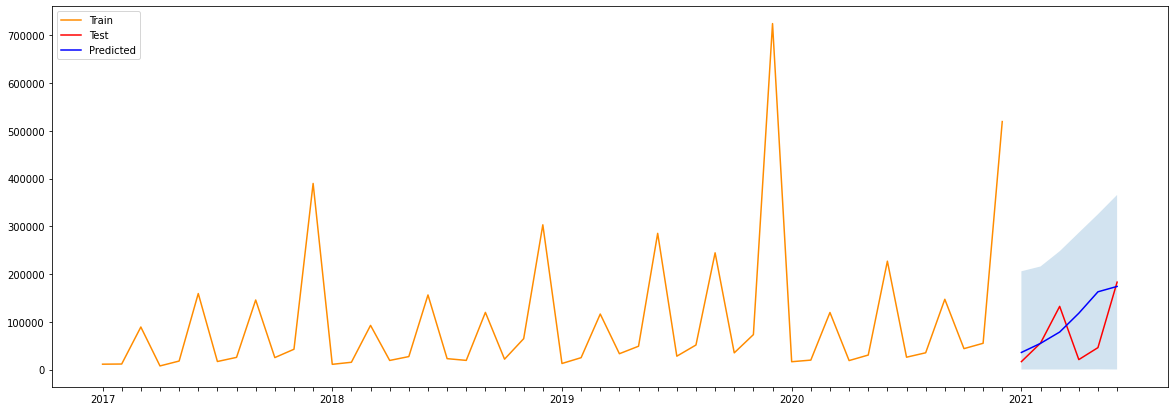

In [36]:
plt.figure(figsize=(20,7))
plt.plot(dates_train, train_values_list, color='darkorange', label="Train")
plt.plot(dates_test, test_values_list, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()